In [2]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import pandas as pd
import lifelines
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [71]:
df_gtd = pd.read_csv('globalterrorismdb_0616dist.csv')

#### Goal
1. To build a predictive model for the GTD Dataset which predicts the terrorist groups.
2. There are 137 features - only certain features are important while building the predictive model.

In [72]:
features = ['iyear','imonth','iday','country','region','city','attacktype1','weaptype1','targtype1','nkill','gname']

In [73]:
df_gtd = df_gtd[features]

In [198]:
df_gtd.head(5)

,iyear,imonth,iday,country,region,city,attacktype1,weaptype1,targtype1,nkill,gname
0,1970,0,0,58,2,Santo Domingo,1,13,14,1,MANO-D
1,1970,0,0,130,1,Mexico city,6,13,7,0,23rd of September Communist League
2,1970,1,0,160,5,Unknown,1,13,10,1,Unknown
3,1970,1,0,78,8,Athens,3,6,7,NaN,Unknown
4,1970,1,0,101,4,Fukouka,7,8,7,NaN,Unknown


In [51]:
df_gtd.describe()

,iyear,imonth,iday,country,region,attacktype1,weaptype1,targtype1,nkill
count,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000,147827.000000
mean,2000.474083,6.484666,15.455215,133.087401,6.970097,3.187081,6.408587,8.305112,2.359237
std,12.982397,3.392225,8.815533,113.946290,2.967803,1.870064,2.130785,6.642518,11.421270
min,1970.000000,0.000000,0.000000,4.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1989.000000,4.000000,8.000000,69.000000,5.000000,2.000000,5.000000,3.000000,0.000000
50%,2005.000000,6.000000,15.000000,101.000000,6.000000,3.000000,6.000000,4.000000,0.000000
75%,2013.000000,9.000000,23.000000,160.000000,10.000000,3.000000,6.000000,14.000000,2.000000
max,2015.000000,12.000000,31.000000,1004.000000,12.000000,9.000000,13.000000,22.000000,1500.000000


#### Number of Killed - Observations

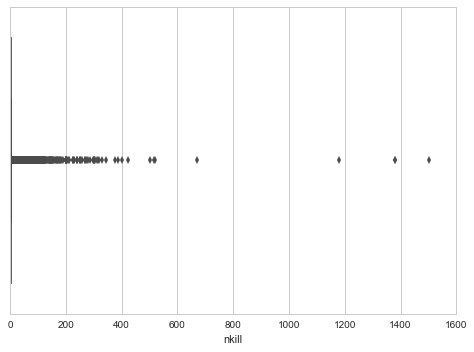

In [98]:
sns.boxplot(x = df_gtd.nkill)

In [40]:
1.0 - sum(df_gtd.nkill.notnull())/float(len(df_gtd))

0.057057382695889558

In [41]:
len(df_gtd.query("nkill<=2"))/float(len(df_gtd))

0.7660998137422499

* We notice that most of the values recorded for count of killed victims seems to be less than 200 
and few attacks have the dead victim counts more than 500, with 1500 being the highest.
* 49% percent of attacks futher seem to have exactly zero victims killed and 75% of attacks seem to have killed atmost 2 people
* 5 % of the attacks do not have the number of victims recorded.(Missing values)

#### Terror Attack with largest dead victims

In [53]:
df_gtd.query("nkill==1500")

,iyear,imonth,iday,country,region,city,attacktype1,weaptype1,targtype1,nkill,gname
133286,2014,6,12,95,10,Tikrit,6,5,4,1500,Islamic State of Iraq and the Levant (ISIL)


* The attack where 1500 victims were dead was in the year 2014 at the city of Tikrit,Iraq on 12 June. 
* It was carried out by the ISIS. 
* This attack part of the 'Northern Iraq Offensive' which began on 5 June 2014 was carried out by ISIS against the Iraq Government.

#### Year of Terror Attacks

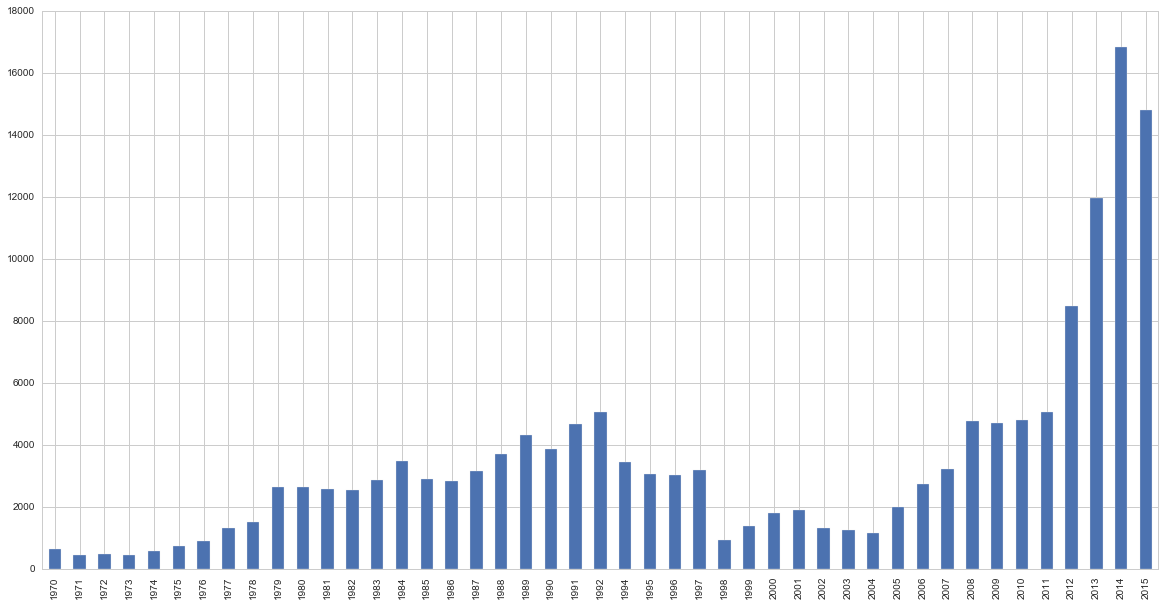

In [102]:
plt.rcParams['figure.figsize'] = (20, 10)
df_gtd.iyear.value_counts().sort_index().plot(kind='bar')

* The difference in levels of attacks before and after 2012, before and afer 1998 and the case of 1993 not being recorded has been detailed at https://www.start.umd.edu/gtd/faq/#q10 ( related to improper data collection intervals)

#### Country

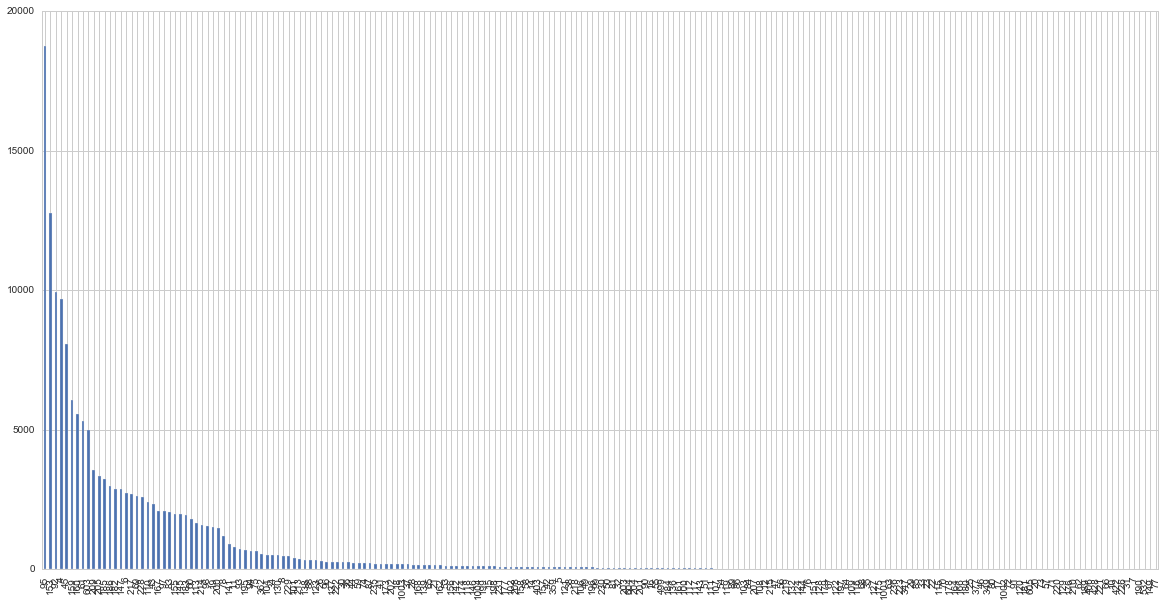

In [107]:
df_gtd.country.value_counts().plot(kind='bar')

* The terror attacks have occured in almost every country there is but as they are concentrated only in few countries.

In [199]:
df_gtd.country.value_counts(normalize=True)[:15]

95     0.119728
153    0.081443
92     0.063404
4      0.061810
45     0.051521
159    0.038814
160    0.035568
61     0.033935
603    0.031842
209    0.022689
205    0.021292
185    0.020661
186    0.019021
182    0.018434
147    0.018422
Name: country, dtype: float64

* Countries - Iraq, Pakistan, Afghanisan, India, Peru,Colombia etc. seem to have the highest proportion of attacks. 
* Iraq seems to have the highest proportion of attacks - almost 12% of attacks.

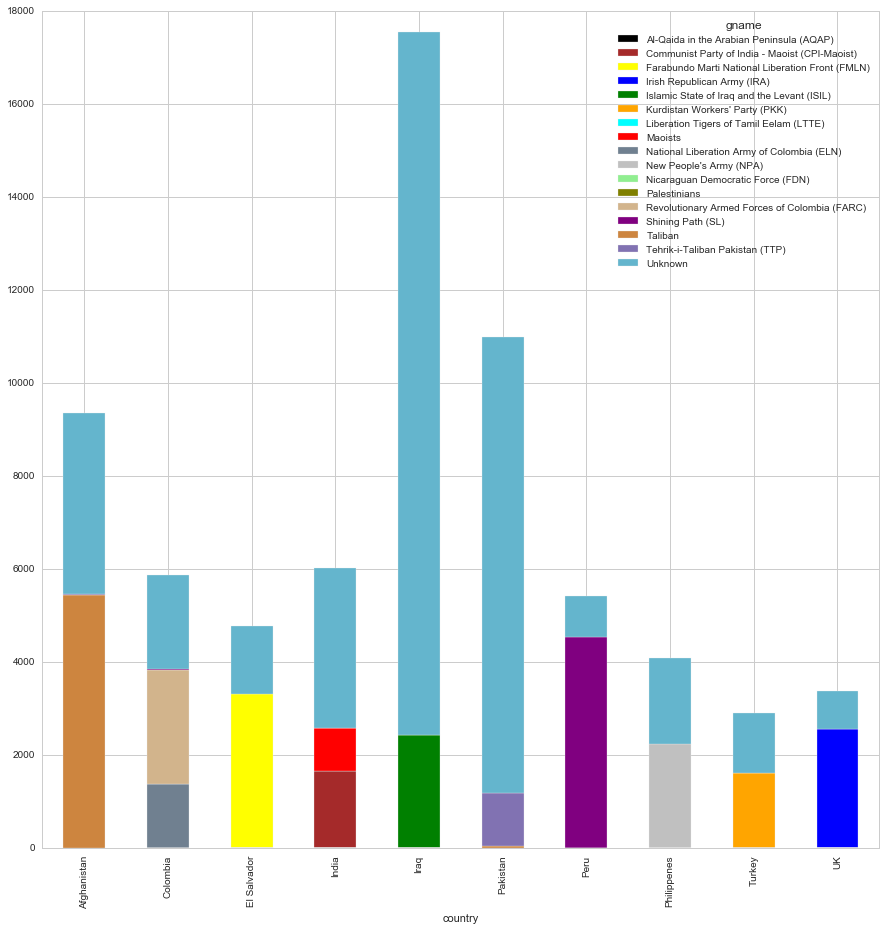

In [217]:
df_gname = pd.DataFrame(df_gtd.gname.value_counts())
df_gname_head = pd.Series(df_gname.head(20).index)
df_gname_head_10 = df_gtd[df_gtd['gname'].isin(df_gname_head)]
tmp = pd.DataFrame(df_gname_head_10.groupby(['country','gname']).size(), columns =['count'])
tmp1 = tmp.reset_index()
vals = df_country_head.values
country_map = {4:'Afghanistan', 95:'Iraq', 153:'Pakistan', 45:'Colombia', 61:'El Salvador', 92:'India', 159:'Peru', 
               160: 'Philippenes',209:'Turkey', 603:'UK'}
tmp2 = tmp1.loc[tmp1['country'].isin(vals)]
tmp2.country = tmp2.country.apply(lambda x: country_map[x])
tmp2 = tmp2.pivot(index='country',columns='gname',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp2.plot(ax=axes,kind='bar', stacked=True, color = ['black', 'brown', 'yellow','blue','green','orange','cyan','red',
                                                    'slategrey','silver','lightgreen','olive','tan','purple','peru','m','c','sage'])

* Across any country, there seems to be a significant proportion of attacks which have not been identified.
* Iraq has a high proportion of attacks which have gone unidientified.
* The attacks in Peru seems to be more attributed to one particular terror group - Shining Path(SL)
* Likewise for El Salvador to the group, FMLN and UK to the IRA.
* Countries like Iraq, Afghnistan, Pakistan (The Middle East countries) have a large proportion of attacks unidientified.
* Countries like India and Colombia are each dominated by attacks by 2 groups apart from a significant number of unidentified 
    attacks.
* Palestinians seem to be the dominant group for Turkey.

#### Attack Type

In [219]:
df_gtd.attacktype1.value_counts(normalize=True)

3    0.484544
2    0.239545
1    0.112150
6    0.058142
7    0.056445
9    0.035019
5    0.005326
8    0.005282
4    0.003547
Name: attacktype1, dtype: float64

* 48 % of attacks are Bombing/Explosion Types, 23% are Armed Assualts.

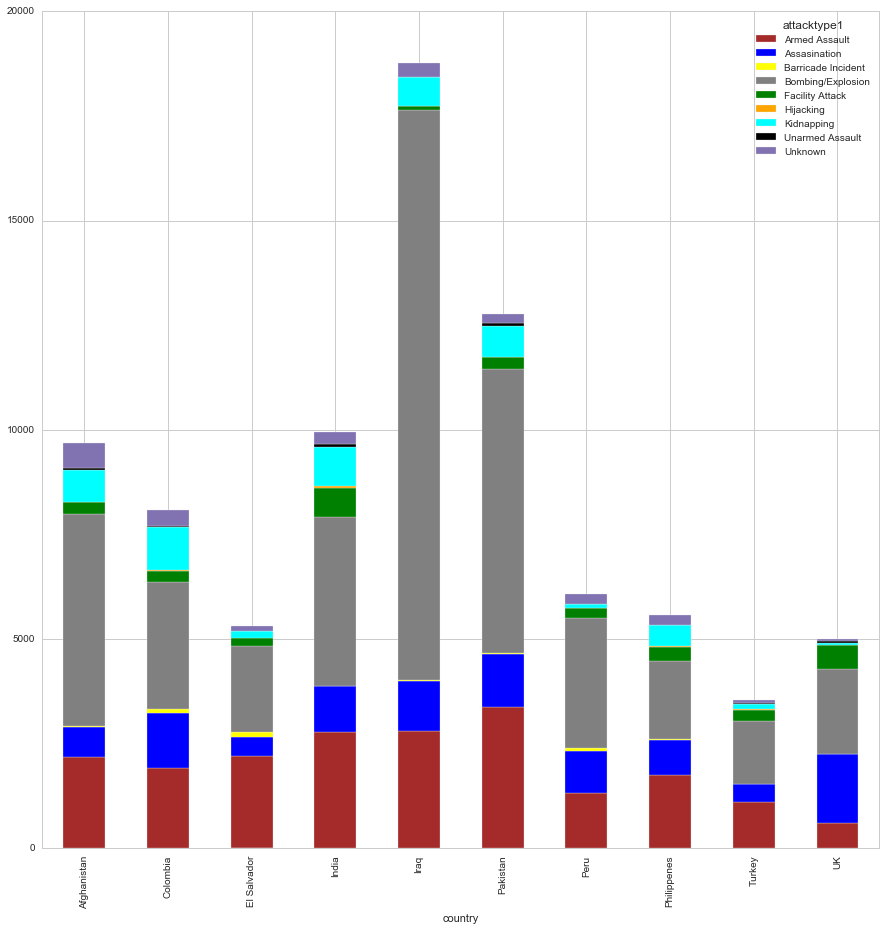

In [225]:
df_attack = pd.DataFrame(df_gtd.attacktype1.value_counts())
df_attack_index = pd.Series(df_attack.index)
df_attack1 = df_gtd[df_gtd['attacktype1'].isin(df_attack_index)]
tmp = pd.DataFrame(df_attack1.groupby(['country','attacktype1']).size(), columns =['count'])
tmp1 = tmp.reset_index()
vals = df_country_head.values
country_map = {4:'Afghanistan', 95:'Iraq', 153:'Pakistan', 45:'Colombia', 61:'El Salvador', 92:'India', 159:'Peru', 
               160: 'Philippenes',209:'Turkey', 603:'UK'}
attack_map = {1:'Assasination', 2:'Armed Assault',6:'Kidnapping',5:'Barricade Incident',3:'Bombing/Explosion',4:'Hijacking',
              7:'Facility Attack', 8:'Unarmed Assault',9:'Unknown'}
tmp2 = tmp1.loc[tmp1['country'].isin(vals)]
tmp2.country = tmp2.country.apply(lambda x: country_map[x])
tmp2.attacktype1 = tmp2.attacktype1.apply(lambda x: attack_map[x])
tmp2 = tmp2.pivot(index='country',columns='attacktype1',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp2.plot(ax=axes,kind='bar', stacked=True, color = ['brown', 'blue', 'yellow','grey','green','orange','cyan','black','m'])

* Across countries, Bombing seems to the dominant attack while Armed Assault also have their presence throughout.
* UK has a similar proportion of Assasinations and Bombing while having fewer Armed Assualts.
* The distribution across countries for other attacks seem to be fairly constant.

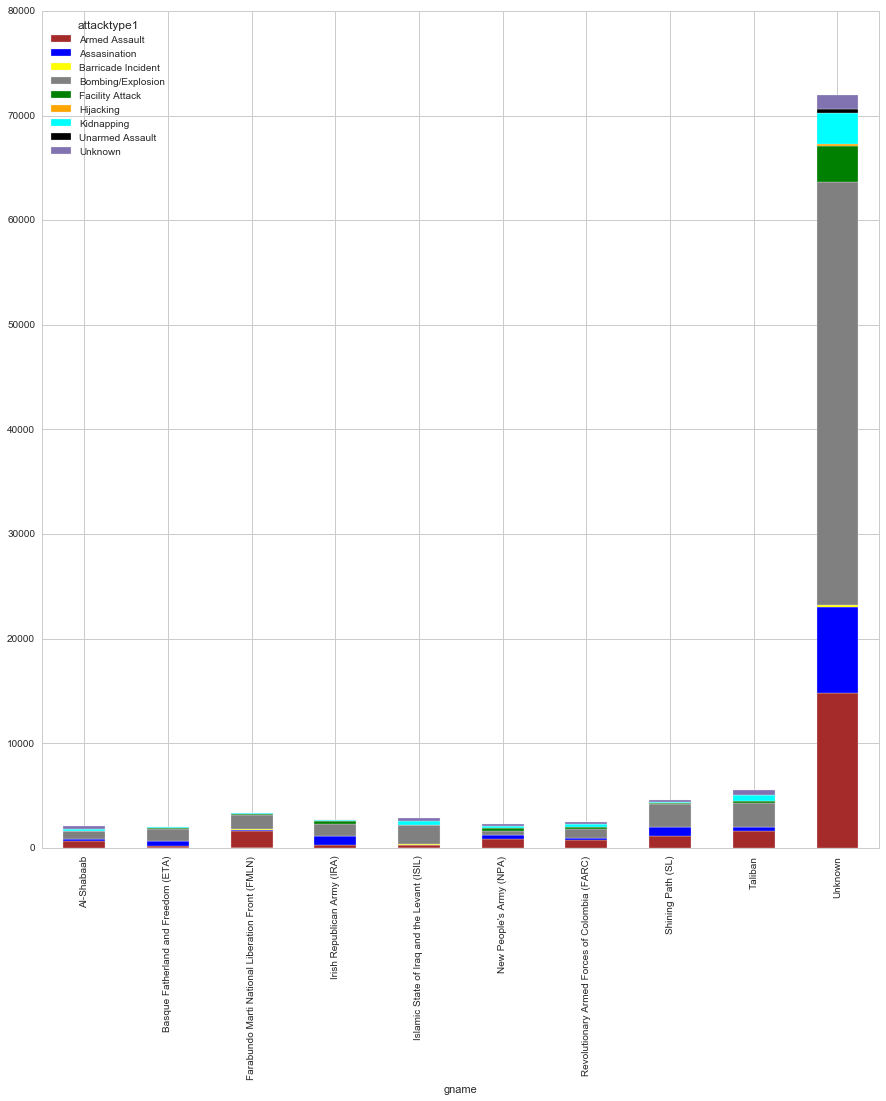

In [231]:
df_attack = pd.DataFrame(df_gtd.attacktype1.value_counts())
df_attack_index = pd.Series(df_attack.index)
df_attack1 = df_gtd[df_gtd['attacktype1'].isin(df_attack_index)]
tmp = pd.DataFrame(df_attack1.groupby(['gname','attacktype1']).size(), columns =['count'])
tmp1 = tmp.reset_index()
df_gname = pd.DataFrame(df_gtd.gname.value_counts())
df_gname_head = pd.Series(df_gname.head(10).index)
vals = df_gname_head.values
attack_map = {1:'Assasination', 2:'Armed Assault',6:'Kidnapping',5:'Barricade Incident',3:'Bombing/Explosion',4:'Hijacking',
              7:'Facility Attack', 8:'Unarmed Assault',9:'Unknown'}
tmp2 = tmp1.loc[tmp1['gname'].isin(vals)]
tmp2.attacktype1 = tmp2.attacktype1.apply(lambda x: attack_map[x])
tmp2 = tmp2.pivot(index='gname',columns='attacktype1',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp2.plot(ax=axes,kind='bar', stacked=True, color = ['brown', 'blue', 'yellow','grey','green','orange','cyan','black','m'])

* The dominant attack type is that of Bombing/Explosion across all the terrorist groups.
* FMLN group uses a significant proportion of attacks thorugh Armed Assaults so is Taliban.
* IRA - responsible for attacks in UK uses Assisination as one major mode of attack.
* The class distribution is highly skewed - Unkown represents a very high proportion of attacks.

#### Weapon Type

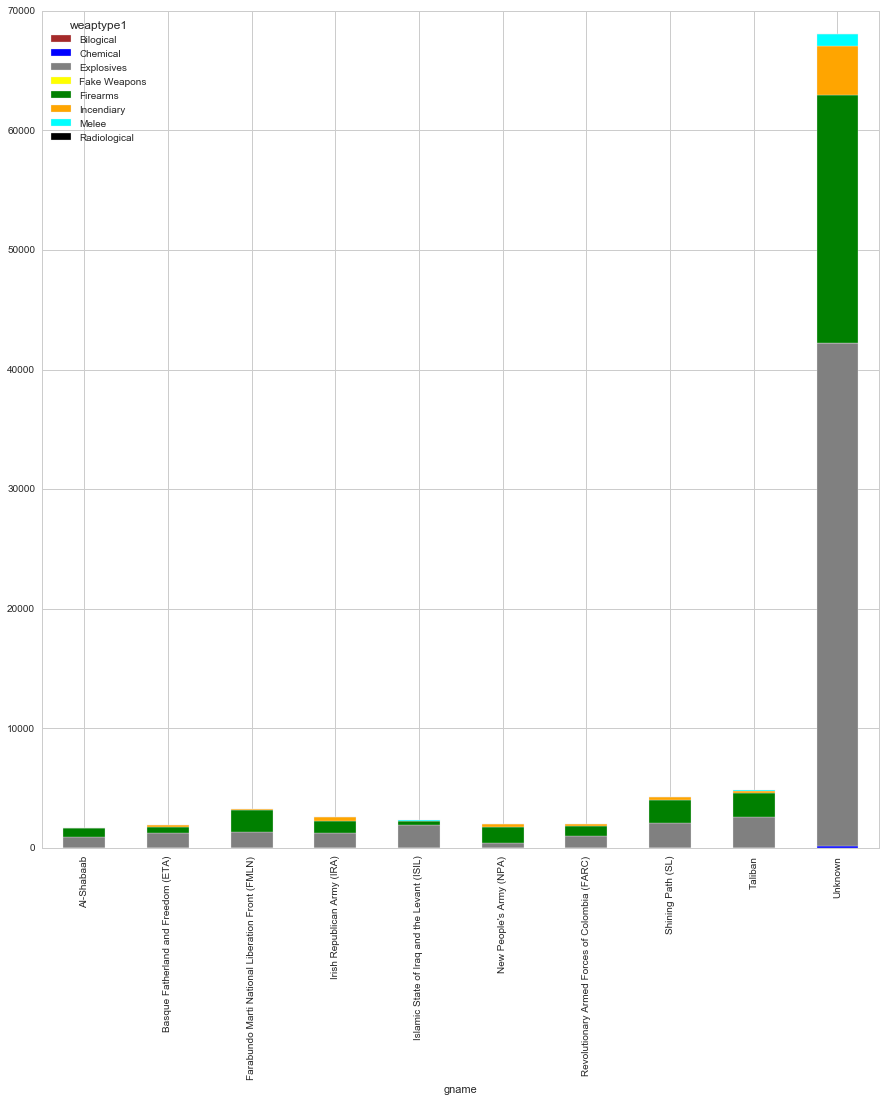

In [237]:
df_weap = pd.DataFrame(df_gtd.weaptype1.value_counts())
df_weap_index = pd.Series(df_attack.index)
df_weap1 = df_gtd[df_gtd['weaptype1'].isin(df_attack_index)]
tmp = pd.DataFrame(df_weap1.groupby(['gname','weaptype1']).size(), columns =['count'])
tmp1 = tmp.reset_index()
df_gname = pd.DataFrame(df_gtd.gname.value_counts())
df_gname_head = pd.Series(df_gname.head(10).index)
vals = df_gname_head.values
weap_map = {1:'Bilogical', 2:'Chemical',6:'Explosives',5:'Firearms',3:'Radiological',4:'Nuclear',
              7:'Fake Weapons', 8:'Incendiary',9:'Melee',10:'Vehicle',11:'Sabotage',12:'Other',13:'Unknown'}
tmp2 = tmp1.loc[tmp1['gname'].isin(vals)]
tmp2.weaptype1 = tmp2.weaptype1.apply(lambda x: weap_map[x])
tmp2 = tmp2.pivot(index='gname',columns='weaptype1',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp2.plot(ax=axes,kind='bar', stacked=True, color = ['brown', 'blue', 'grey','yellow','green','orange','cyan','black','m'])

* 3 weapons are most popular - Explosives, Firearms and Incendiary across all thr groups.
* The terror group, ISIS uses explosives almost exclusively as their mode of attacks.

#### Target Type

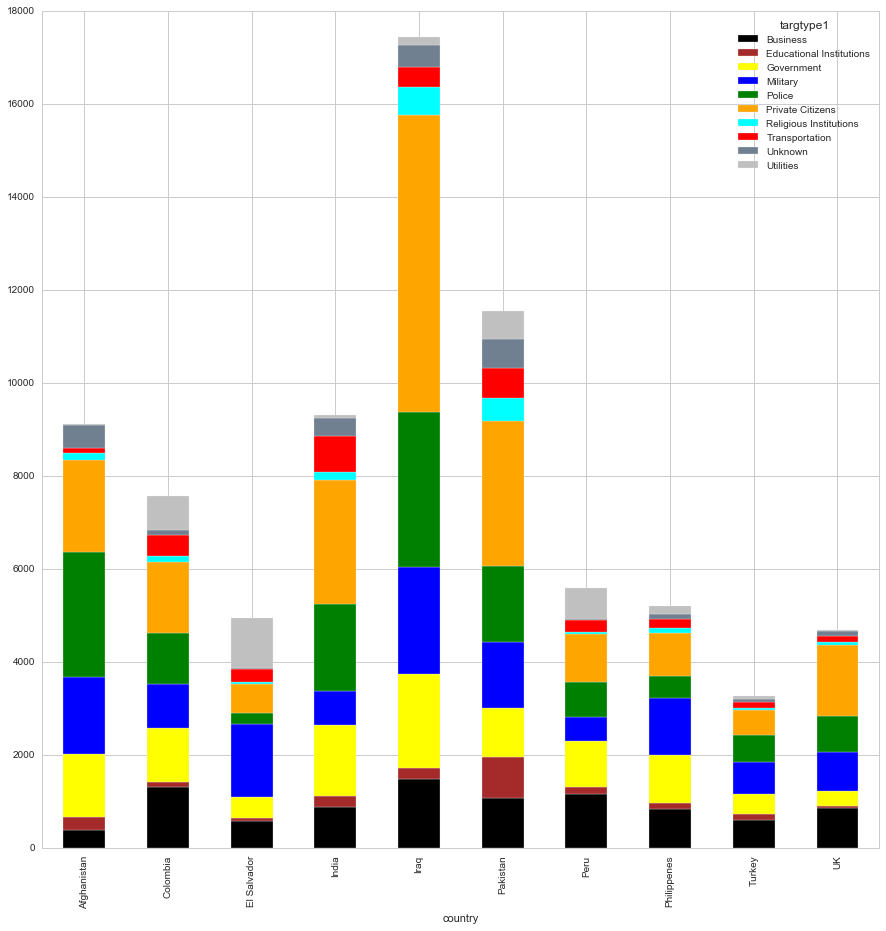

In [242]:
df_target = pd.DataFrame(df_gtd.targtype1.value_counts())
df_target_head = pd.Series(df_target.head(10).index)
df_target_head_10 = df_gtd[df_gtd['targtype1'].isin(df_target_head)]
tmp = pd.DataFrame(df_target_head_10.groupby(['country','targtype1']).size(), columns =['count'])
tmp1 = tmp.reset_index()
vals = df_country_head.values
country_map = {4:'Afghanistan', 95:'Iraq', 153:'Pakistan', 45:'Colombia', 61:'El Salvador', 92:'India', 159:'Peru', 
               160: 'Philippenes',209:'Turkey', 603:'UK'}
targ_map = {1:'Business',2:'Government',3:'Police',4:'Military',
            8:'Educational Institutions',14:'Private Citizens',15:'Religious Institutions',
            19:'Transportation',20:'Unknown',21:'Utilities'}
tmp2 = tmp1.loc[tmp1['country'].isin(vals)]
tmp2.country = tmp2.country.apply(lambda x: country_map[x])
tmp2.targtype1 = tmp2.targtype1.apply(lambda x: targ_map[x])
tmp2 = tmp2.pivot(index='country',columns='targtype1',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp2.plot(ax=axes,kind='bar', stacked=True, color = ['black', 'brown', 'yellow','blue','green','orange','cyan','red',
                                                    'slategrey','silver','lightgreen','olive','tan','purple','peru','m','c','sage'])

* A large proportion of attacks seem to be directed at the Public across the countries.
* Attacks directed at  the Government as well as the Police also dominate the distribution.
* While there has been a small representation of attacks against Educational Institutions, surpisingly UK seems to have a very
     negligible representation.

In [269]:
df_nkill_gname = df_gname_head_10.groupby('gname').sum()

In [275]:
df_nkill_gname = df_nkill_gname.reset_index()

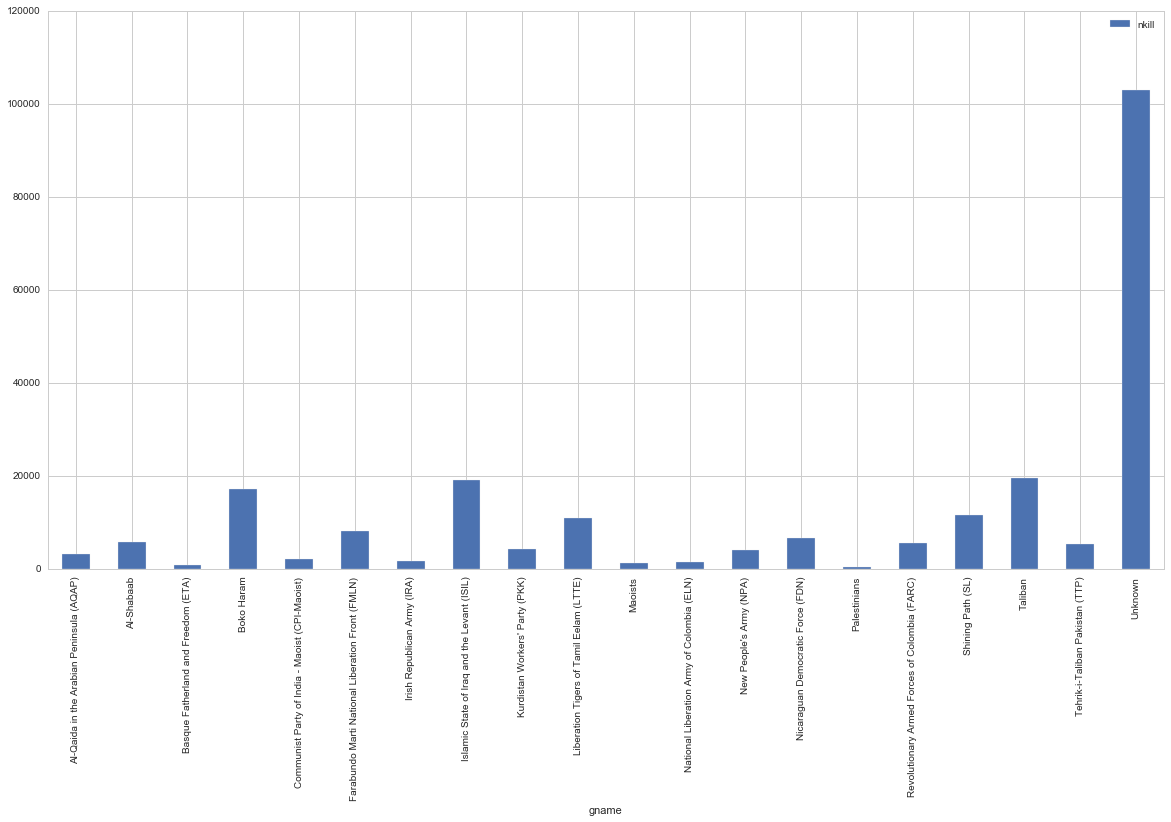

In [278]:
df_nkill_gname.plot('gname','nkill',kind='bar')

* Taliban, Boko Haram and ISIS seem to the 3 terror groups contributing to most number of dead victims through their terror attacks.

#### Missing Values

In [74]:
df_gtd.apply(lambda x: sum(x.isnull()),axis=0) 

iyear             0
imonth            0
iday              0
country           0
region            0
city            446
attacktype1       0
weaptype1         0
targtype1         0
nkill          8945
gname             0
dtype: int64

* To fill in the missing values for city, one can replace them with the modal city for that particular country.

* To fill in the missing values for the count of dead victims, they can be replaced with the median value i.e. 0.

In [75]:
df_gtd.nkill = df_gtd.nkill.fillna(0)

In [76]:
df_city = df_gtd.city
city_missing_indices = list(df_city.index[df_city.isnull()])
country_city_map = {}
for element in list(df_gtd.country.unique()):
    df = df_gtd.loc[df_gtd['country'] == element]
    country_city_map[element] = df.city.value_counts().index[0]
list_cities = [country_city_map[row.country] if index in city_missing_indices else row.city for index, row in df_gtd.iterrows()]
df_gtd.city = list_cities

#### Convert categorical features to numerical

In [77]:
df_gtd.dtypes

iyear            int64
imonth           int64
iday             int64
country          int64
region           int64
city            object
attacktype1      int64
weaptype1        int64
targtype1        int64
nkill          float64
gname           object
dtype: object

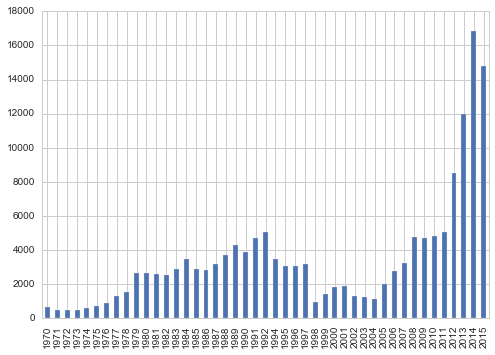

In [78]:
df_gtd.iyear.value_counts().sort_index().plot(kind='bar')

In [79]:
list_years = df_gtd.iyear.unique()
map_years = {}
for year in list_years:
    if year < 1997:
        map_years[year] = 0
    elif year >= 1997 and year <= 2008:
        map_years[year] = 1
    else:
        map_years[year] = 2
categ_years = list()
for year in df_gtd.iyear:
    categ_years.append(map_years[year])
df_gtd['year_cat'] = categ_years

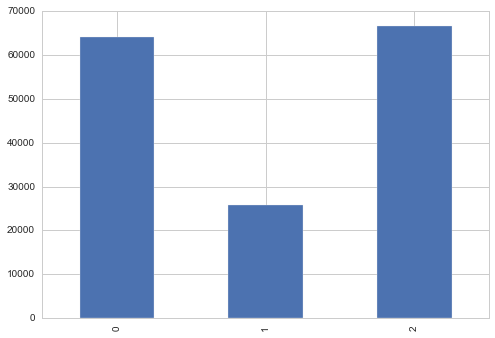

In [80]:
df_gtd.year_cat.value_counts().sort_index().plot(kind='bar')

In [81]:
df_gtd = df_gtd.drop('iyear',1)

In [82]:
df_gtd.dtypes

imonth           int64
iday             int64
country          int64
region           int64
city            object
attacktype1      int64
weaptype1        int64
targtype1        int64
nkill          float64
gname           object
year_cat         int64
dtype: object

In [83]:
df2 = df_gtd
df1 = df_gtd

In [101]:
df_year = pd.get_dummies(df1['year_cat'])
df_month = pd.get_dummies(df1['imonth'])
df_day = pd.get_dummies(df1['iday'])
df_country = pd.get_dummies(df1['country'])
df_region = pd.get_dummies(df1['region'])
df_attack = pd.get_dummies(df1['attacktype1'])
df_weap = pd.get_dummies(df1['weaptype1'])
df_targ = pd.get_dummies(df1['targtype1'])

In [104]:
column_dfs = [df_year,df_month,df_day,df_country,df_region,df_attack,df_weap,df_targ]
df1_concat = pd.concat(column_dfs,axis=1)

In [113]:
df_nkill_gname = df[['nkill','gname']]

In [114]:
df1_concat = pd.concat([df1_concat,df_nkill_gname],axis=1)

In [116]:
df_encoded = df1_concat

In [122]:
print df_year.shape[1], df_month.shape[1], df_day.shape[1], df_country.shape[1], df_region.shape[1], df_attack.shape[1], df_weap.shape[1], df_targ.shape[1]

3 13 32 206 12 9 12 22


In [124]:
col_year = ['year' + str(i) for i in range(0,3)]

In [126]:
col_month =['month' + str(i) for i in range(0,13)]
col_day = ['day' + str(i) for i in range(0, 32)]
col_country = ['country' + str(i) for i in range(0,206)]
col_region =['region' + str(i) for i in range(0,12)]
col_attack =['attack' + str(i) for i in range(0,9)]
col_weap = ['weap' + str(i) for i in range(0,12)]
col_targ = ['targ' + str(i) for i in range(0,22)]

In [128]:
list_cols_new = col_year + col_month + col_day + col_country + col_region + col_attack + col_weap + col_targ

In [131]:
df_encoded.columns = list_cols_new + ['nkill','gname']

In [ ]:
#### def 